# Medyczne zastosowania uczenia maszynowego - zadanie 4

# Temat: Klastrowanie danych medycznych

Analiza zbiorów danych dotyczących raka prostaty, zawierających próbki moczu, surowicy i tkanek

Katarzyna Pieczonka, nr indeksu 132785 <br/>
Informatyka II stopień, semestr zimowy <br/>
rok akademicki 2024/25

1. Wczytanie bibliotek i zbiorów danych

In [48]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

In [34]:
#Odczytanie zbiorów danych
datasetM = pd.read_csv('FTIR_800-1800_mocz_1chory_0zdrowy.csv', delimiter=';', dtype=float, decimal=',') #Dane rozdzielone są średnikami
datasetS = pd.read_csv('FTIR_800-1800_surowica_1chory_0zdrowy.csv', delimiter=';', dtype=float, decimal=',')
datasetT = pd.read_csv('FTIR_800-1800_tkanka_1chory_0zdrowy.csv', delimiter=';', dtype=float, decimal=',')

noColumn1 = datasetM.shape[1]
noColumn2 = datasetS.shape[1]
noColumn3 = datasetT.shape[1]

print(f"Dataset1 - próbki moczu: \n\n {datasetM.head()}")
print(f"Dataset2 - próbki surowicy: \n\n {datasetS.head()}")
print(f"Dataset3 - próbki tkanek: \n\n {datasetT.head()}")

column_namesM = datasetM.columns[:-1] #Wszystkie nazwy kolumn w każdym ze zbiorów danych
column_namesS = datasetS.columns[:-1]
column_namesT = datasetT.columns[:-1]

Dataset1 - próbki moczu: 

    800.31372  800.79584  801.27796  801.76007  802.24219  802.72431  \
0    0.15608    0.15398    0.15202    0.15021    0.14849    0.14676   
1    0.18841    0.18582    0.18343    0.18128    0.17932    0.17746   
2    0.21911    0.21687    0.21493    0.21324    0.21162    0.20987   
3    0.12812    0.12601    0.12409    0.12236    0.12073    0.11910   
4    0.16763    0.16522    0.16306    0.16113    0.15932    0.15754   

   803.20642  803.68854  804.17066  804.65277  ...  1796.84919  1797.3313  \
0    0.14498    0.14316    0.14136    0.13965  ...     0.02749    0.02584   
1    0.17564    0.17384    0.17212    0.17054  ...     0.02380    0.02214   
2    0.20785    0.20556    0.20316    0.20084  ...     0.02588    0.02379   
3    0.11740    0.11562    0.11382    0.11209  ...     0.02655    0.02465   
4    0.15569    0.15379    0.15190    0.15012  ...     0.02583    0.02380   

   1797.81342  1798.29554  1798.77765  1799.25977  1799.74189  1800.224  \
0     0

2. Przygotowanie zbiorów danych - sprawdzanie brakujących wartości i usuwanie duplikatów.

In [35]:
#Sprawdzanie braków danych w dataset1
print("Liczba brakujących wartości dla poszczególnych kolumn w dataset1:")
missing_values = datasetM.isnull().sum()
for col, value in missing_values.items():
    if value != 0:
        print(f"{col}, brak: {value} wartości")

#Sprawdzanie duplikatów w dataset1
duplicates = datasetM.duplicated().sum()
print(f"Duplikaty: {duplicates}")
print("Usuwanie duplikatów: ")
datasetM = datasetM.drop_duplicates() #Funkcja usuwająca duplikaty
duplicates = datasetM.duplicated().sum()
print(f"Duplikaty: {duplicates}")

#####################################################

#Sprawdzanie braków danych w dataset2
print("Liczba brakujących wartości dla poszczególnych kolumn w dataset2:")
missing_values2 = datasetS.isnull().sum()
for col, value in missing_values2.items():
    if value != 0:
        print(f"{col}, brak: {value} wartości")

#Sprawdzanie duplikatów w dataset2
duplicates2 = datasetS.duplicated().sum()
print(f"Duplikaty: {duplicates2}")
print("Usuwanie duplikatów: ")
datasetS = datasetS.drop_duplicates()
duplicates2 = datasetS.duplicated().sum()
print(f"Duplikaty: {duplicates2}")

####################################################

#Sprawdzanie braków danych w dataset3
print("Liczba brakujących wartości dla poszczególnych kolumn w dataset3:")
missing_values3 = datasetT.isnull().sum()
for col, value in missing_values3.items():
    if value != 0:
        print(f"{col}, brak: {value} wartości")

#Sprawdzanie duplikatów w dataset3
duplicates3 = datasetT.duplicated().sum()
print(f"Duplikaty: {duplicates3}")
print("Usuwanie duplikatów: ")
datasetT = datasetT.drop_duplicates()
duplicates3 = datasetT.duplicated().sum()
print(f"Duplikaty: {duplicates3}")

Liczba brakujących wartości dla poszczególnych kolumn w dataset1:
Duplikaty: 2
Usuwanie duplikatów: 
Duplikaty: 0
Liczba brakujących wartości dla poszczególnych kolumn w dataset2:
Duplikaty: 0
Usuwanie duplikatów: 
Duplikaty: 0
Liczba brakujących wartości dla poszczególnych kolumn w dataset3:
Duplikaty: 2
Usuwanie duplikatów: 
Duplikaty: 0


In [36]:
#Dane bez eytkiety Class
dataM = datasetM.iloc[:, :-1].values
dataS = datasetS.iloc[:, :-1].values
dataT = datasetT.iloc[:, :-1].values

#Tylko etykiety klas
labelsM = datasetM["Class"].values 
labelsS = datasetS["Class"].values
labelsT = datasetT["Class"].values

# Normalizacja danych

In [37]:
scaler = StandardScaler()
dataM = scaler.fit_transform(dataM)
dataS = scaler.fit_transform(dataS)
dataT = scaler.fit_transform(dataT)

# Funkcja do obliczania DBSCAN

In [38]:
def dbscan(eps, min_samples, data, labels):
    results = []

    # Tworzenie modelu DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    cluster_labels = db.labels_
    
    # Identyfikacja próbek będących szumem
    num_noise = np.sum(cluster_labels == -1)
    
    # Liczebność klastrów
    unique_clusters, cluster_counts = np.unique(cluster_labels[cluster_labels != -1], return_counts=True)
    
    # Obliczenie współczynnika Silhouette (pomijamy szum)
    if len(unique_clusters) > 1:
        silhouette_avg = silhouette_score(data, cluster_labels, metric="euclidean")
    else:
        silhouette_avg = -1  # Jeśli tylko jeden klaster
    
    # Porównanie z rzeczywistymi etykietami (tylko dla punktów niebędących szumem)
    valid_indices = cluster_labels != -1
    adjusted_rand = adjusted_rand_score(labels[valid_indices], cluster_labels[valid_indices])

     # Analiza poprawnych i błędnych klasyfikacji
    valid_cluster_labels = cluster_labels[valid_indices]
    valid_true_labels = labels[valid_indices]

    # Mapowanie klastrów na rzeczywiste klasy
    df = pd.DataFrame({
        "Cluster": valid_cluster_labels,
        "True_Class": valid_true_labels
    })

    cluster_mapping = {}
    for cluster in df["Cluster"].unique():
        most_common_class = df[df["Cluster"] == cluster]["True_Class"].mode()[0]
        cluster_mapping[cluster] = most_common_class

    # Zamiana etykiet klastrów na klasy
    predicted_classes = df["Cluster"].map(cluster_mapping)

    # Obliczenie poprawnych i błędnych klasyfikacji
    df["Correct"] = (predicted_classes == df["True_Class"])
    num_correct = df["Correct"].sum()
    num_incorrect = len(df) - num_correct
    
    results.append({
        "num_clusters": len(unique_clusters),
        "num_noise": num_noise,
        "silhouette_score": silhouette_avg,
        "adjusted_rand_score": adjusted_rand,
        "num_correct": num_correct,
        "num_incorrect": num_incorrect,
    })
    
    # Wizualizacja klastrów za pomocą PCA, czyli redukcji wymiarowości, która pozwala
    # na stworzenie takiej wizualizacji w 2D w przypadku, gdy mamy więcej cech
    pca = PCA(n_components=2)
    data_reduced = pca.fit_transform(data)
    
    plt.figure(figsize=(8, 6))
    for cluster in unique_clusters:
        plt.scatter(
            data_reduced[cluster_labels == cluster, 0],
            data_reduced[cluster_labels == cluster, 1],
            label=f"Cluster {cluster}"
        )
    
    # Oznaczenie szumu
    plt.scatter(
        data_reduced[cluster_labels == -1, 0],
        data_reduced[cluster_labels == -1, 1],
        color="black", label="Noise"
    )
    
    plt.title(f"DBSCAN (eps = {eps}, min_samples = {min_samples})")
    plt.legend()
    plt.show()
    return results


Obliczane wartości:
- num_clusters - liczba klastrów rozpoznanych przez algorytm DBSCAN.
- num_noise - liczba próbek zidentyfikowanych jako szum
- silhouette_score - miara używana do jakości klastrowania, informuje jak dobrze obiekty są przypisane do swoich klastrów w porównaniu z innymi klastrami. Zakres wartości to 1 do -1. Wartość 1 oznacza wyraźne, dobrze oddzielone klastry, natomiast wartości bliższe 0 oznaczają, że punkty są na granicy klastrów. -1 oznacza błędy w klastrowaniu (zwracany jest w szczególności w przypadku występowania tylko 1 klastra) 
- adjusted_rand_score - miara używana do oceny jakości klastrowania, porównująca wyniki klastrowania z rzeczywistymi etykietami klas. Jeśli wynik wychodzi blisko 1, to znaczy, że klasy są dobrze odwzorowane w klastrach; jeśli wynik jest bliższy 0, to znaczy, że klastry są losowe i klasy nie zostały prawidłowo odwzorowane. Ujemne wyniki oznaczają bardzo złe dopasowane
- num_correct - liczba próbek z klasą zidentyfikowaną poprawnie
- num_incorrect - liczba próbek z klasą zidentyfikowaną niepoprawnie

# Dataset z próbkami moczu

Macierz odległości służy wyznaczeniu maksymalnej odległości pomiędzy punktami, która pozwala na prawidłową identyfikację klastrów. Odczytuje się ją z wykresu, w miejscu w którym odległości zaczynają gwałtownie rosnąć

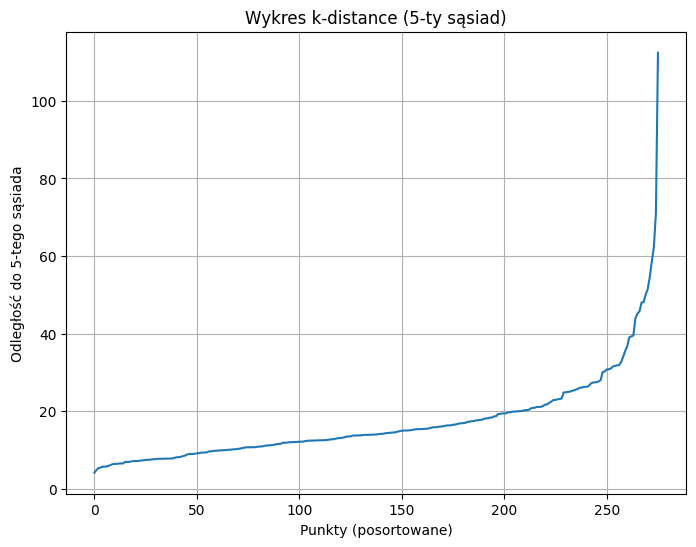

In [39]:
# Macierz odległości - wyznaczenie wielkości eps, czyli maksymalnej odległości między punktami w klastrze

# Obliczenie macierzy odległości
distances = pairwise_distances(dataM)

# Posortowanie odległości i wybranie najbliższych sąsiadów
sorted_distances = np.sort(distances, axis=1)
k_distances = sorted_distances[:, 5]  # 5-ty sąsiad (zależne od min_samples)

# Wykres "k-distance"
plt.figure(figsize=(8, 6))
plt.plot(np.sort(k_distances))
plt.title("Wykres k-distance (5-ty sąsiad)")
plt.xlabel("Punkty (posortowane)")
plt.ylabel("Odległość do 5-tego sąsiada")
plt.grid()
plt.show()

In [40]:
dbscan_params = [
    {"eps": 35.0, "min_samples": 5},
    {"eps": 35.0, "min_samples": 10},
    {"eps": 40.0, "min_samples": 5},
]

#eps to maksymalna odległość między punktami w klastrze
#min_samples to minimalna liczba punktów w klastrze, aby nie uznać ich za szum

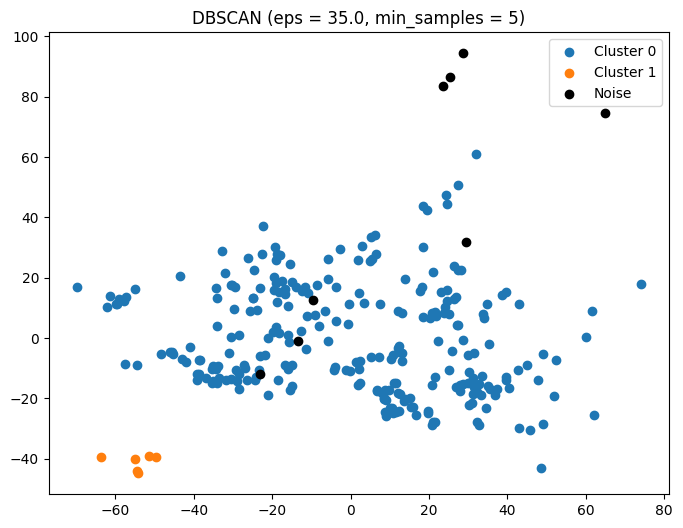

   num_clusters  num_noise  silhouette_score  adjusted_rand_score  \
0             2          8          0.389167             0.015553   

   num_correct  num_incorrect  
0          158            110  


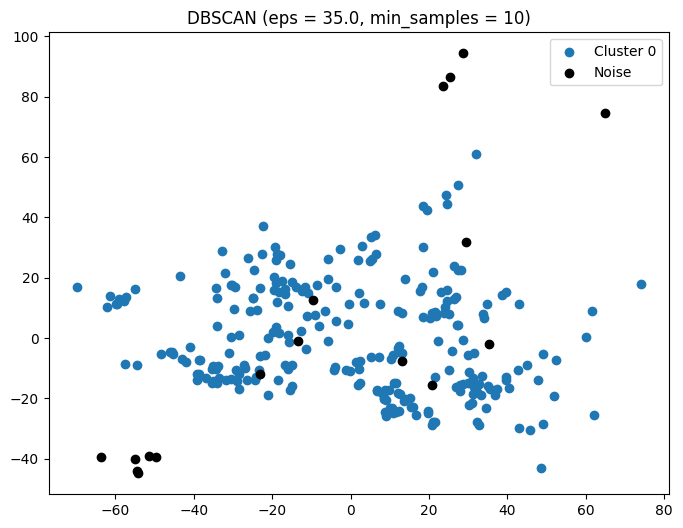

   num_clusters  num_noise  silhouette_score  adjusted_rand_score  \
0             1         17                -1                  0.0   

   num_correct  num_incorrect  
0          149            110  


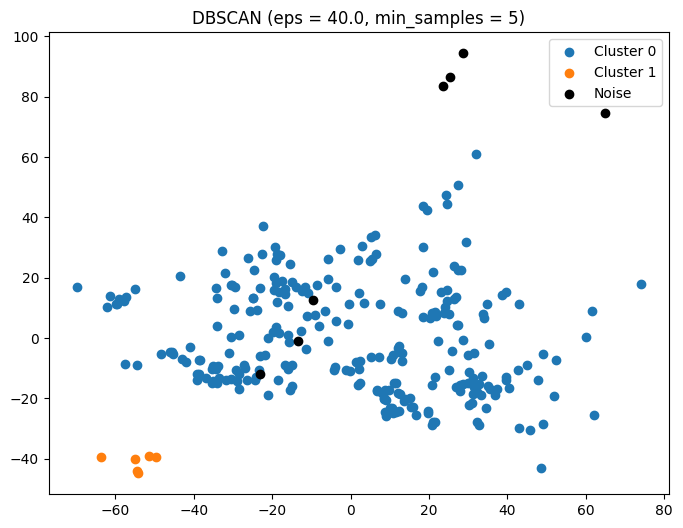

   num_clusters  num_noise  silhouette_score  adjusted_rand_score  \
0             2          7          0.398541             0.015872   

   num_correct  num_incorrect  
0          159            110  


In [41]:
for params in dbscan_params:
    result = dbscan(params['eps'],params['min_samples'],dataM, labelsM)
    results_df = pd.DataFrame(result)
    print(results_df)

Wnioski:
- dla eps równego 35 i 40 i minimalnej ilości punktów w klastrze równej 5 silhouette score wynosi około 0.4, co nie jest idealną wartością (klastry nie są wyraźne, a punkty znajdują się na granicy między klasami), jednak jest to wystarczające, by wyznaczyć 2 klastry, czego oczekujemy w przypadku danych medycznych (klasy zdrowy/chory). Są to jednak najbardziej optymalne parametry.
Przy większych wartościach min_samples liczba klastrów nie została określona prawidłowo
- liczba punktów uznawanych za szum nie jest duża, jednak dość duża liczba punktów klasyfikowana jest nieprawidłowo
- wynik adjusted rand score świadczy o tym, że klasy nie zostały dość dobrze odwzorowane w klastrach

# Dataset z próbkami surowicy

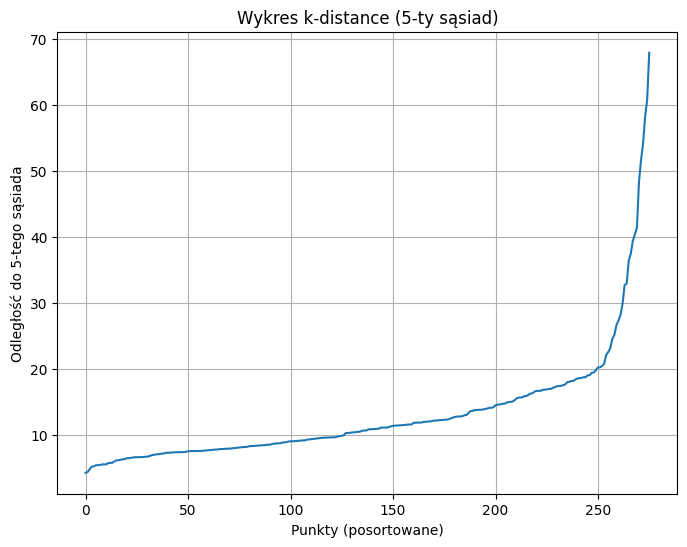

In [42]:
# Macierz odległości - wyznaczenie wielkości eps, czyli maksymalnej odległości między punktami w klastrze

# Obliczenie macierzy odległości
distances = pairwise_distances(dataS)

# Posortowanie odległości i wybranie najbliższych sąsiadów
sorted_distances = np.sort(distances, axis=1)
k_distances = sorted_distances[:, 5]  # 5-ty sąsiad (zależne od min_samples)

# Wykres "k-distance"
plt.figure(figsize=(8, 6))
plt.plot(np.sort(k_distances))
plt.title("Wykres k-distance (5-ty sąsiad)")
plt.xlabel("Punkty (posortowane)")
plt.ylabel("Odległość do 5-tego sąsiada")
plt.grid()
plt.show()

In [43]:
dbscan_params = [
    {"eps": 20.0, "min_samples": 10},
    {"eps": 25.0, "min_samples": 5},
    {"eps": 25.0, "min_samples": 10},
]

#eps to maksymalna odległość między punktami w klastrze
#min_samples to minimalna liczba punktów w klastrze, aby nie uznać ich za szum

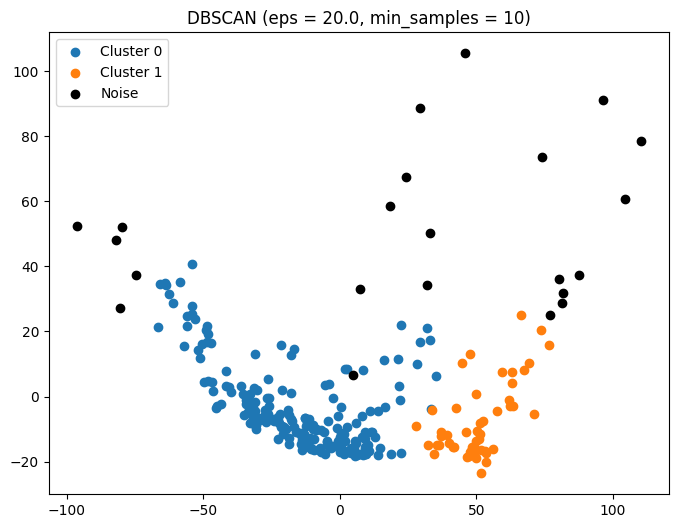

   num_clusters  num_noise  silhouette_score  adjusted_rand_score  \
0             2         22          0.447347             0.034899   

   num_correct  num_incorrect  
0          154            100  


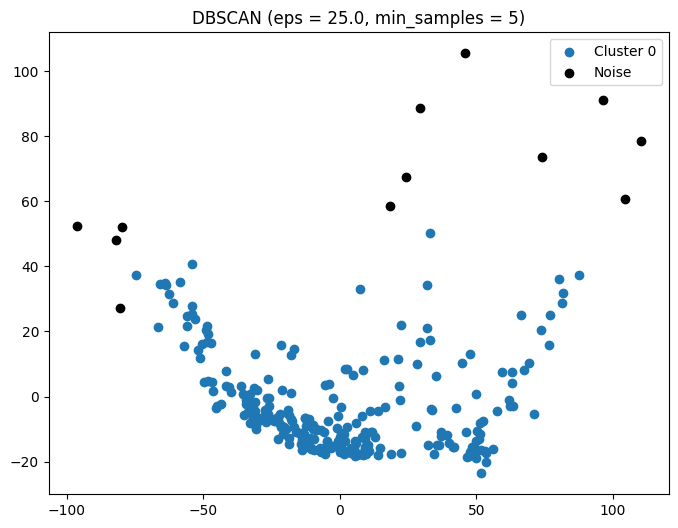

   num_clusters  num_noise  silhouette_score  adjusted_rand_score  \
0             1         12                -1                  0.0   

   num_correct  num_incorrect  
0          151            113  


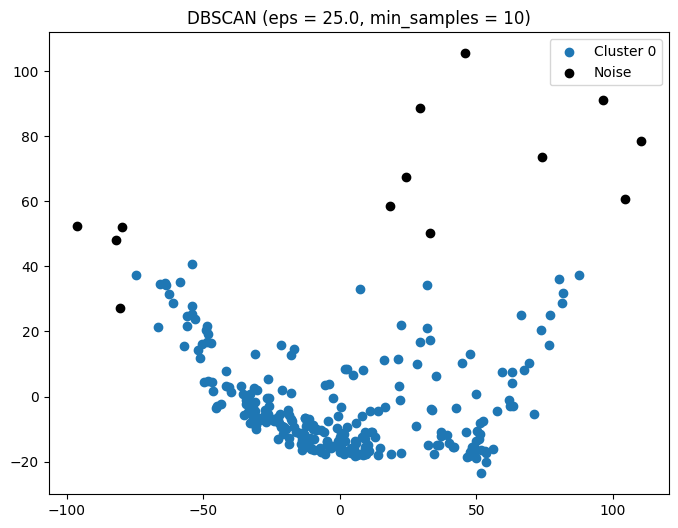

   num_clusters  num_noise  silhouette_score  adjusted_rand_score  \
0             1         13                -1                  0.0   

   num_correct  num_incorrect  
0          150            113  


In [44]:
for params in dbscan_params:
    result = dbscan(params['eps'],params['min_samples'],dataS, labelsS)
    results_df = pd.DataFrame(result)
    print(results_df)

Wnioski:
- Najbardziej optymalne parametry dla tego zbioru danych to eps = 20 i min_samples = 10. 
Przy większych wartościach eps liczba klastrów nie została określona prawidłowo
- liczba punktów uznawanych za szum nie jest duża, jednak większa niż w przypadku zbioru z próbkami moczu. Nadal dość duża liczba punktów klasyfikowana jest nieprawidłowo
- wynik adjusted rand score świadczy o tym, że klasy nie zostały dość dobrze odwzorowane w klastrach, jednak jest on wyższy niż w przypadku zbioru z próbkami moczu. Podobnie silhouette_score

# Dataset z próbkami tkanek

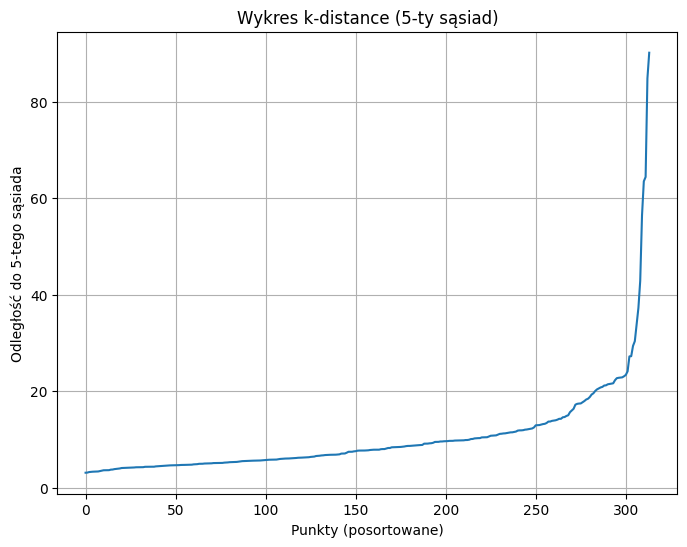

In [45]:
# Macierz odległości - wyznaczenie wielkości eps, czyli maksymalnej odległości między punktami w klastrze

# Obliczenie macierzy odległości
distances = pairwise_distances(dataT)

# Posortowanie odległości i wybranie najbliższych sąsiadów
sorted_distances = np.sort(distances, axis=1)
k_distances = sorted_distances[:, 5]  # 5-ty sąsiad (zależne od min_samples)

# Wykres "k-distance"
plt.figure(figsize=(8, 6))
plt.plot(np.sort(k_distances))
plt.title("Wykres k-distance (5-ty sąsiad)")
plt.xlabel("Punkty (posortowane)")
plt.ylabel("Odległość do 5-tego sąsiada")
plt.grid()
plt.show()

In [46]:
dbscan_params = [
    {"eps": 15.0, "min_samples": 5},
    {"eps": 20.0, "min_samples": 5},
    {"eps": 20.0, "min_samples": 10},
]

#eps to maksymalna odległość między punktami w klastrze
#min_samples to minimalna liczba punktów w klastrze, aby nie uznać ich za szum

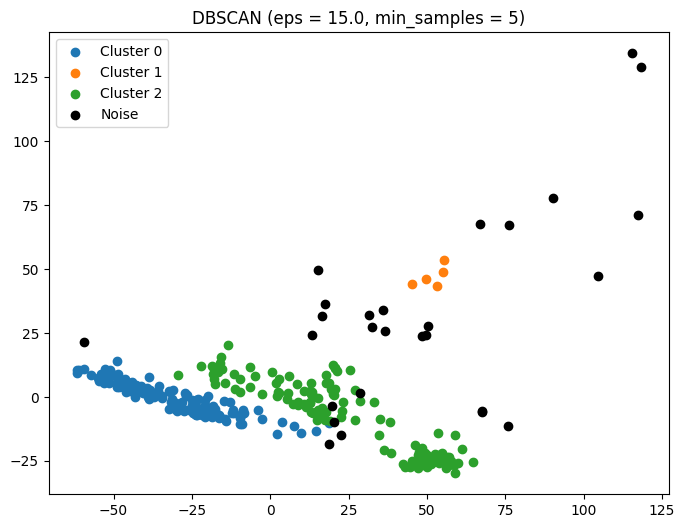

   num_clusters  num_noise  silhouette_score  adjusted_rand_score  \
0             3         27          0.398265             0.968324   

   num_correct  num_incorrect  
0          287              0  


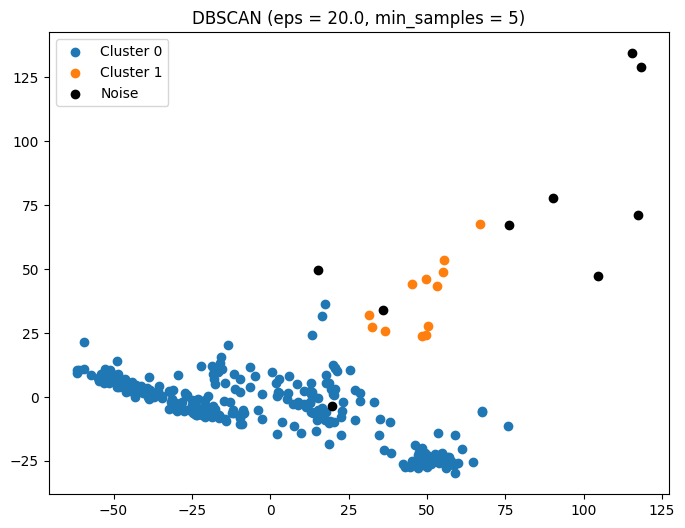

   num_clusters  num_noise  silhouette_score  adjusted_rand_score  \
0             2          9           0.33773             0.009395   

   num_correct  num_incorrect  
0          168            137  


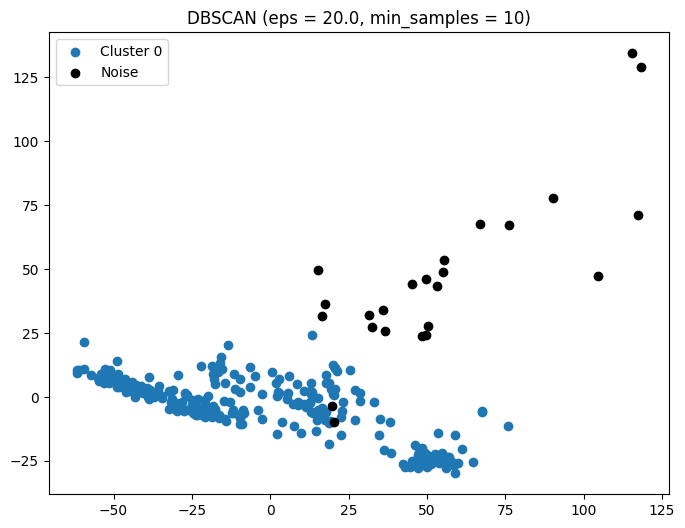

   num_clusters  num_noise  silhouette_score  adjusted_rand_score  \
0             1         24                -1                  0.0   

   num_correct  num_incorrect  
0          155            135  


In [47]:
for params in dbscan_params:
    result = dbscan(params['eps'],params['min_samples'],dataT, labelsT)
    results_df = pd.DataFrame(result)
    print(results_df)

Wnioski:
- Najbardziej optymalne parametry w tym przypadku to eps = 20, a min_samples = 5. W przypadku mniejszego eps odnajdywana jest zbyt duża liczba klastrów, a w przypadku większego min_samples niż 5, liczba klastrów jest zbyt mała.
- w przypadku prawidłowej ilości zidentyfikowanych klastrów liczba punktów uznawanych za szum nie jest duża, jednak wciąż dość duża liczba punktów klasyfikowana jest nieprawidłowo
- wynik adjusted rand score świadczy o tym, że klasy nie zostały dość dobrze odwzorowane w klastrach. Jest on najniższy z wszystkich zbiorów danych

Ogólne wnioski: 
Algorytm DBSCAN nie wydaje się być dobrze dopasowanym do tych danych

# Scenariusz 2 - funkcja do obliczania kMeans

In [62]:
# Funkcja dla kMeans z różnymi metrykami
def kmeans_clustering(data, labels, metric, minkowski_p=3):
    
    # KMeans z k=2
    kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
    kmeans.fit(data)

    # Przypisanie klastrów
    cluster_labels = kmeans.labels_

    # Liczebność klastrów
    unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
    
    # Obliczanie BSS/TSS
    centers = kmeans.cluster_centers_
    overall_mean = np.mean(data, axis=0)
    bss = np.sum([counts[i] * np.linalg.norm(center - overall_mean)**2 for i, center in enumerate(centers)])
    tss = np.sum([np.linalg.norm(point - overall_mean)**2 for point in data])
    bss_tss_ratio = bss / tss

    # Obliczenie liczby błędnych przypisań
    incorrect_assignments = np.sum(labels != cluster_labels)

    # Redukcja wymiarów dla wizualizacji
    pca = PCA(n_components=2)
    data_reduced = pca.fit_transform(data)

    # Wizualizacja klastrów
    plt.figure(figsize=(8, 6))
    for cluster in unique_clusters:
        plt.scatter(
            data_reduced[cluster_labels == cluster, 0],
            data_reduced[cluster_labels == cluster, 1],
            label=f"Cluster {cluster}"
        )
    plt.title(f"kMeans Klastry dla metryki ({metric})")
    plt.legend()
    plt.show()

    return {
        "num_clusters": len(unique_clusters),
        "counts": counts,
        "bss_tss_ratio": bss_tss_ratio,
        "incorrect_assignments": incorrect_assignments
    }


Jakość klastrów jest tutaj określana za pomocą stosunku BSS/TSS (Stosunek Between Sum of Squares (BSS) do Total Sum of Squares (TSS)), gdzie im wyższa wartość (od 0 do 1), tym lepsze jest zgrupowanie 

# Dataset z próbkami moczu


Wyniki dla metryki manhattan:


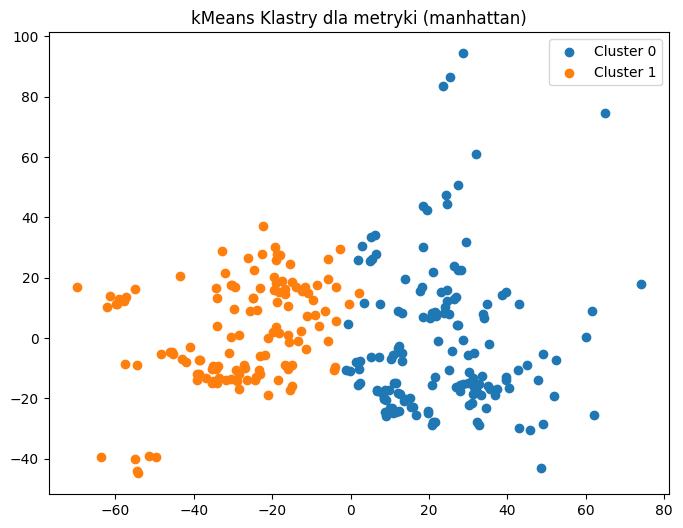

   num_clusters  counts  bss_tss_ratio  incorrect_assignments
0             2     150       0.318735                    137
1             2     126       0.318735                    137

Wyniki dla metryki euclidean:


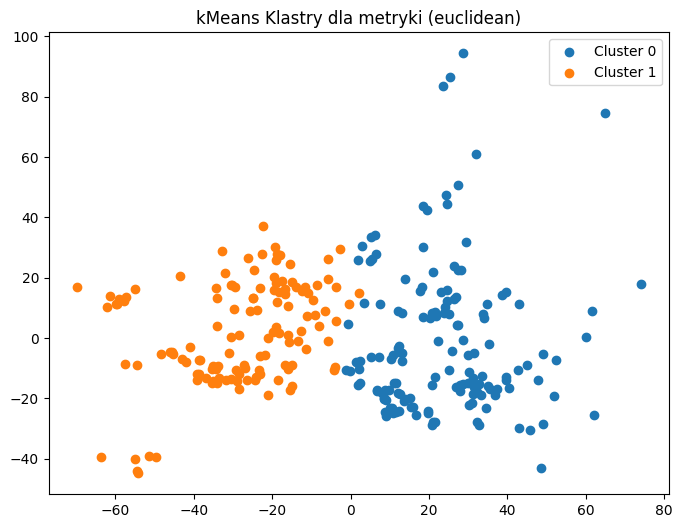

   num_clusters  counts  bss_tss_ratio  incorrect_assignments
0             2     150       0.318735                    137
1             2     126       0.318735                    137

Wyniki dla metryki minkowski:


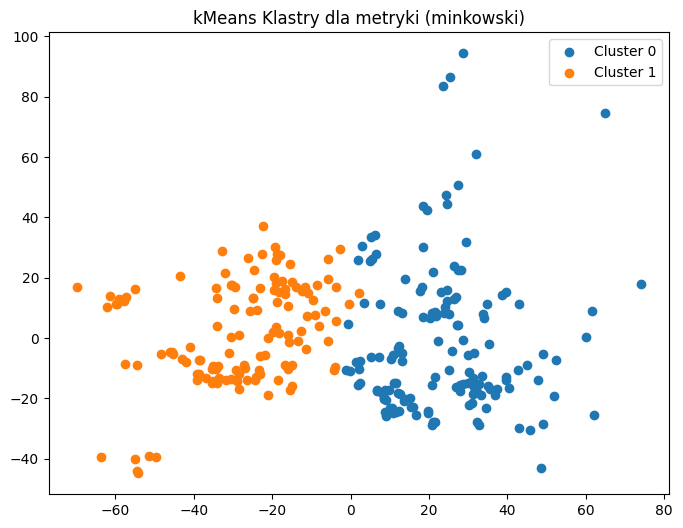

   num_clusters  counts  bss_tss_ratio  incorrect_assignments
0             2     150       0.318735                    137
1             2     126       0.318735                    137


In [63]:
for metric in ['manhattan', 'euclidean', 'minkowski']:
    print(f"\nWyniki dla metryki {metric}:")
    results = kmeans_clustering(dataM, labelsM, metric)
    results = pd.DataFrame(results)
    print(results)

# Dataset z próbkami surowicy


Wyniki dla metryki manhattan:


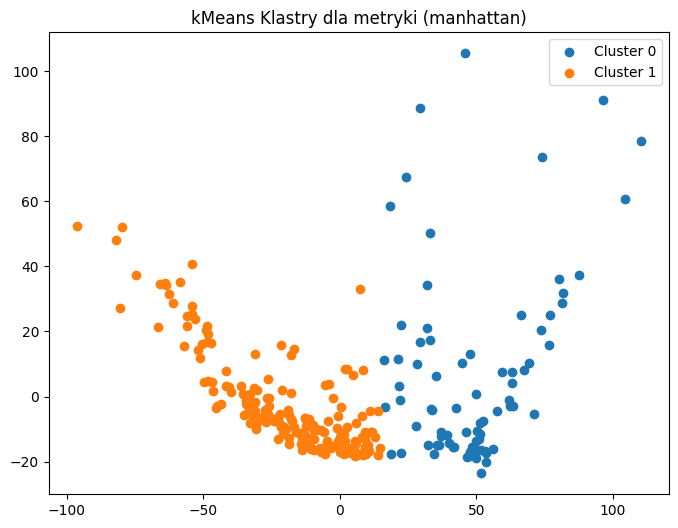

   num_clusters  counts  bss_tss_ratio  incorrect_assignments
0             2      79       0.474007                    100
1             2     197       0.474007                    100

Wyniki dla metryki euclidean:


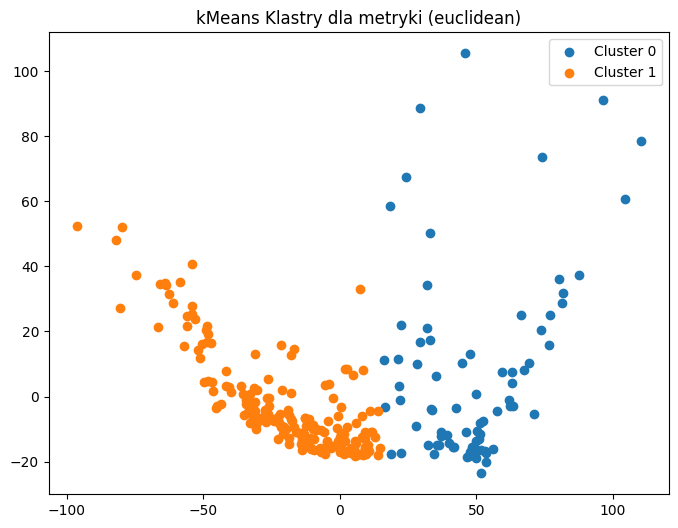

   num_clusters  counts  bss_tss_ratio  incorrect_assignments
0             2      79       0.474007                    100
1             2     197       0.474007                    100

Wyniki dla metryki minkowski:


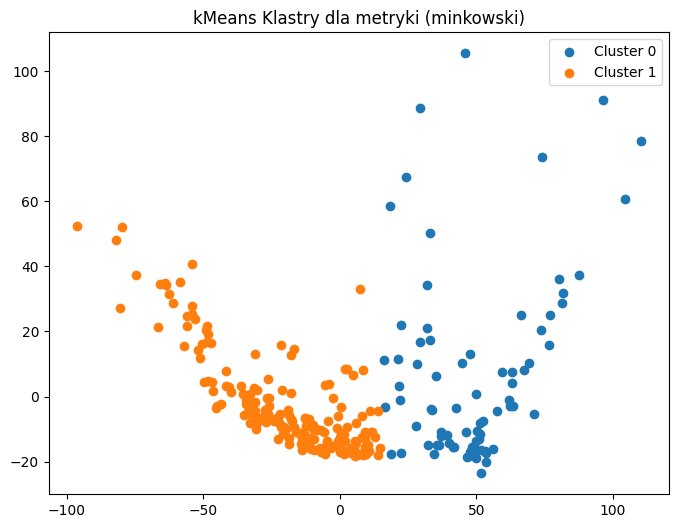

   num_clusters  counts  bss_tss_ratio  incorrect_assignments
0             2      79       0.474007                    100
1             2     197       0.474007                    100


In [64]:
for metric in ['manhattan', 'euclidean', 'minkowski']:
    print(f"\nWyniki dla metryki {metric}:")
    results = kmeans_clustering(dataS, labelsS, metric)
    results = pd.DataFrame(results)
    print(results)

# Dataset z próbkami tkanek


Wyniki dla metryki manhattan:


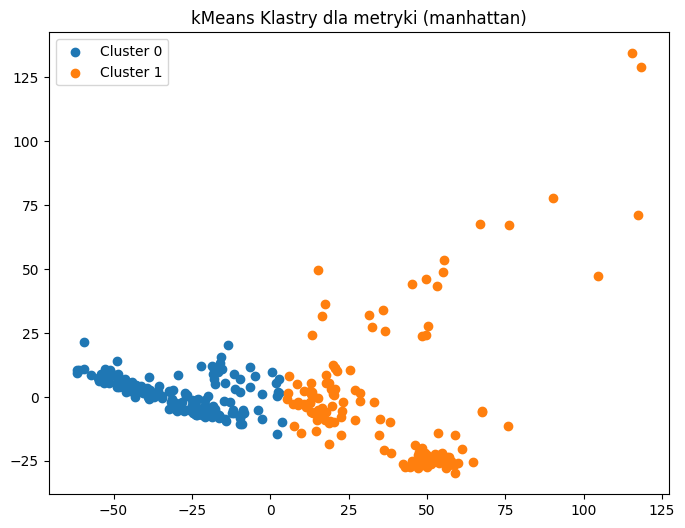

   num_clusters  counts  bss_tss_ratio  incorrect_assignments
0             2     175       0.538994                     36
1             2     139       0.538994                     36

Wyniki dla metryki euclidean:


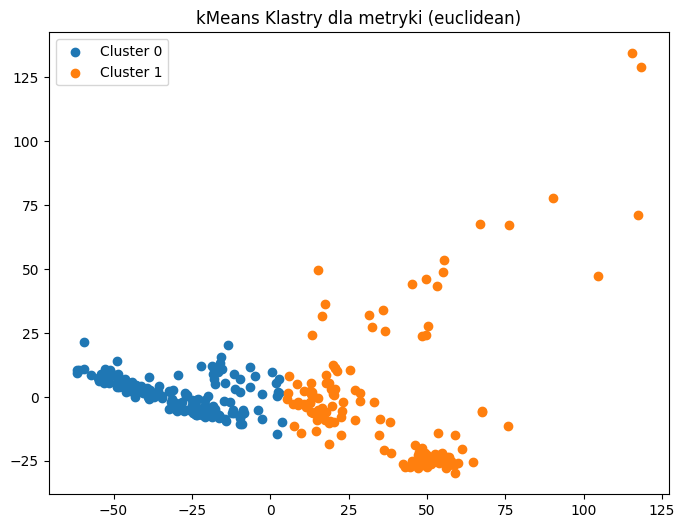

   num_clusters  counts  bss_tss_ratio  incorrect_assignments
0             2     175       0.538994                     36
1             2     139       0.538994                     36

Wyniki dla metryki minkowski:


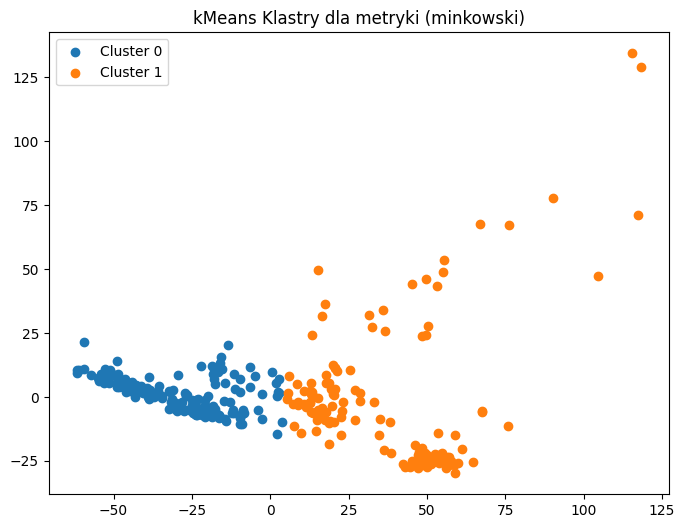

   num_clusters  counts  bss_tss_ratio  incorrect_assignments
0             2     175       0.538994                     36
1             2     139       0.538994                     36


In [65]:
for metric in ['manhattan', 'euclidean', 'minkowski']:
    print(f"\nWyniki dla metryki {metric}:")
    results = kmeans_clustering(dataT, labelsT, metric)
    results = pd.DataFrame(results)
    print(results)

Wnioski: Metoda kMeans z różnymi metrykami wydaje się być lepiej dopasowana do powyższych zbiorów danych niż algorymt DBSCAN. 
Szczególnie w przypadku zbioru z próbkami tkanek, ilość nieprawidłowo sklasyfikowanych próbek jest stosunkowo niewielka. Jakość klastrów wciąż nie jest wysoka (oscyluje zakresie od około 0.3 w przypadku próbek moczu do 0.5 w przypadku próbek tkanek), jednak jest ona lepsza od wyników uzyskanych przez DBSCAN